In [1]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

PROJECT_ROOT = os.getcwd()
TRAIN_DIR = os.path.join(PROJECT_ROOT, "train")
VAL_DIR   = os.path.join(PROJECT_ROOT, "val")
TEST_DIR  = os.path.join(PROJECT_ROOT, "test")

BATCH_SIZE = 32
LR = 1e-4          # un peu plus petit que CNN simple car modèle pré-entraîné
EPOCHS = 10        # on commence soft, souvent ça suffit pour voir la différence
IMG_SIZE = 224     # ResNet attend du 224x224 (ImageNet)

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=eval_tf)
test_ds  = datasets.ImageFolder(TEST_DIR,  transform=eval_tf)

num_classes = len(train_ds.classes)
class_names = train_ds.classes
print("Nombre de classes :", num_classes)
print("Exemples de classes :", class_names[:10])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Device: cuda
Nombre de classes : 38
Exemples de classes : ['apple_apple_scab', 'apple_black_rot', 'apple_cedar_apple_rust', 'apple_healthy', 'blueberry_healthy', 'cherry_healthy', 'cherry_powdery_mildew', 'corn_cercospora_leaf_spot_gray_leaf_spot', 'corn_common_rust', 'corn_healthy']


In [2]:
from torchvision.models import ResNet18_Weights

def build_resnet18(num_classes, freeze_backbone=True):
    # Charger le modèle avec poids ImageNet
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    # Optionnel : geler les couches convolutionnelles
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    # Remplacer la tête finale pour notre classification multi-maladies plantes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model

resnet_model = build_resnet18(num_classes, freeze_backbone=True).to(device)

print(resnet_model)
print(f"Paramètres entraînables : {sum(p.numel() for p in resnet_model.parameters() if p.requires_grad):,}")
print(f"Paramètres totaux       : {sum(p.numel() for p in resnet_model.parameters()):,}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ENNHILI YASSINE/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    [p for p in resnet_model.parameters() if p.requires_grad],
    lr=LR
)

best_val_acc_resnet = 0.0
resnet_best_path = os.path.join(PROJECT_ROOT, "resnet18_best.pth")

for epoch in range(1, EPOCHS+1):
    # ---- TRAIN ----
    resnet_model.train()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = resnet_model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_count += y.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = 100 * total_correct / max(1, total_count)

    # ---- VAL ----
    resnet_model.eval()
    val_correct = 0
    val_count = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = resnet_model(x)
            preds = logits.argmax(dim=1)
            val_correct += (preds == y).sum().item()
            val_count += y.size(0)

    val_acc = 100 * val_correct / max(1, val_count)

    print(f"[ResNet18][Epoch {epoch}/{EPOCHS}] Train Loss={train_loss:.4f} | Train Acc={train_acc:.2f}% | Val Acc={val_acc:.2f}%")

    # sauvegarde du meilleur modèle ResNet18
    if val_acc > best_val_acc_resnet:
        best_val_acc_resnet = val_acc
        torch.save(resnet_model.state_dict(), resnet_best_path)
        print(f" Nouveau meilleur ResNet sauvegardé ({val_acc:.2f}%) -> {resnet_best_path}")


[ResNet18][Epoch 1/10] Train Loss=2.1012 | Train Acc=52.03% | Val Acc=55.14%
 Nouveau meilleur ResNet sauvegardé (55.14%) -> C:\Users\ENNHILI YASSINE\Desktop\CV_Project\resnet18_best.pth
[ResNet18][Epoch 2/10] Train Loss=1.1888 | Train Acc=76.67% | Val Acc=68.77%
 Nouveau meilleur ResNet sauvegardé (68.77%) -> C:\Users\ENNHILI YASSINE\Desktop\CV_Project\resnet18_best.pth
[ResNet18][Epoch 3/10] Train Loss=0.8595 | Train Acc=82.42% | Val Acc=77.02%
 Nouveau meilleur ResNet sauvegardé (77.02%) -> C:\Users\ENNHILI YASSINE\Desktop\CV_Project\resnet18_best.pth
[ResNet18][Epoch 4/10] Train Loss=0.6837 | Train Acc=85.60% | Val Acc=81.51%
 Nouveau meilleur ResNet sauvegardé (81.51%) -> C:\Users\ENNHILI YASSINE\Desktop\CV_Project\resnet18_best.pth
[ResNet18][Epoch 5/10] Train Loss=0.5752 | Train Acc=87.47% | Val Acc=83.68%
 Nouveau meilleur ResNet sauvegardé (83.68%) -> C:\Users\ENNHILI YASSINE\Desktop\CV_Project\resnet18_best.pth
[ResNet18][Epoch 6/10] Train Loss=0.5063 | Train Acc=88.63% | Val

In [5]:
# recharge meilleur modèle
resnet_eval = build_resnet18(num_classes, freeze_backbone=True).to(device)
resnet_eval.load_state_dict(torch.load(resnet_best_path, map_location=device))
resnet_eval.eval()

y_true_res = []
y_pred_res = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = resnet_eval(x)
        preds = logits.argmax(dim=1).cpu().numpy()

        y_pred_res.extend(list(preds))
        y_true_res.extend(list(y.numpy()))

acc_res = accuracy_score(y_true_res, y_pred_res) * 100
prec_res = precision_score(y_true_res, y_pred_res, average="macro", zero_division=0) * 100
rec_res  = recall_score(y_true_res, y_pred_res, average="macro", zero_division=0) * 100
f1_res   = f1_score(y_true_res, y_pred_res, average="macro", zero_division=0) * 100

print("\n📊 Évaluation ResNet18 (test)")
print(f"Accuracy     : {acc_res:.2f}%")
print(f"Précision    : {prec_res:.2f}%")
print(f"Rappel       : {rec_res:.2f}%")
print(f"F1-score     : {f1_res:.2f}%")
print(f"(Meilleur modèle chargé depuis {resnet_best_path})")



📊 Évaluation ResNet18 (test)
Accuracy     : 88.65%
Précision    : 88.45%
Rappel       : 86.70%
F1-score     : 86.67%
(Meilleur modèle chargé depuis C:\Users\ENNHILI YASSINE\Desktop\CV_Project\resnet18_best.pth)


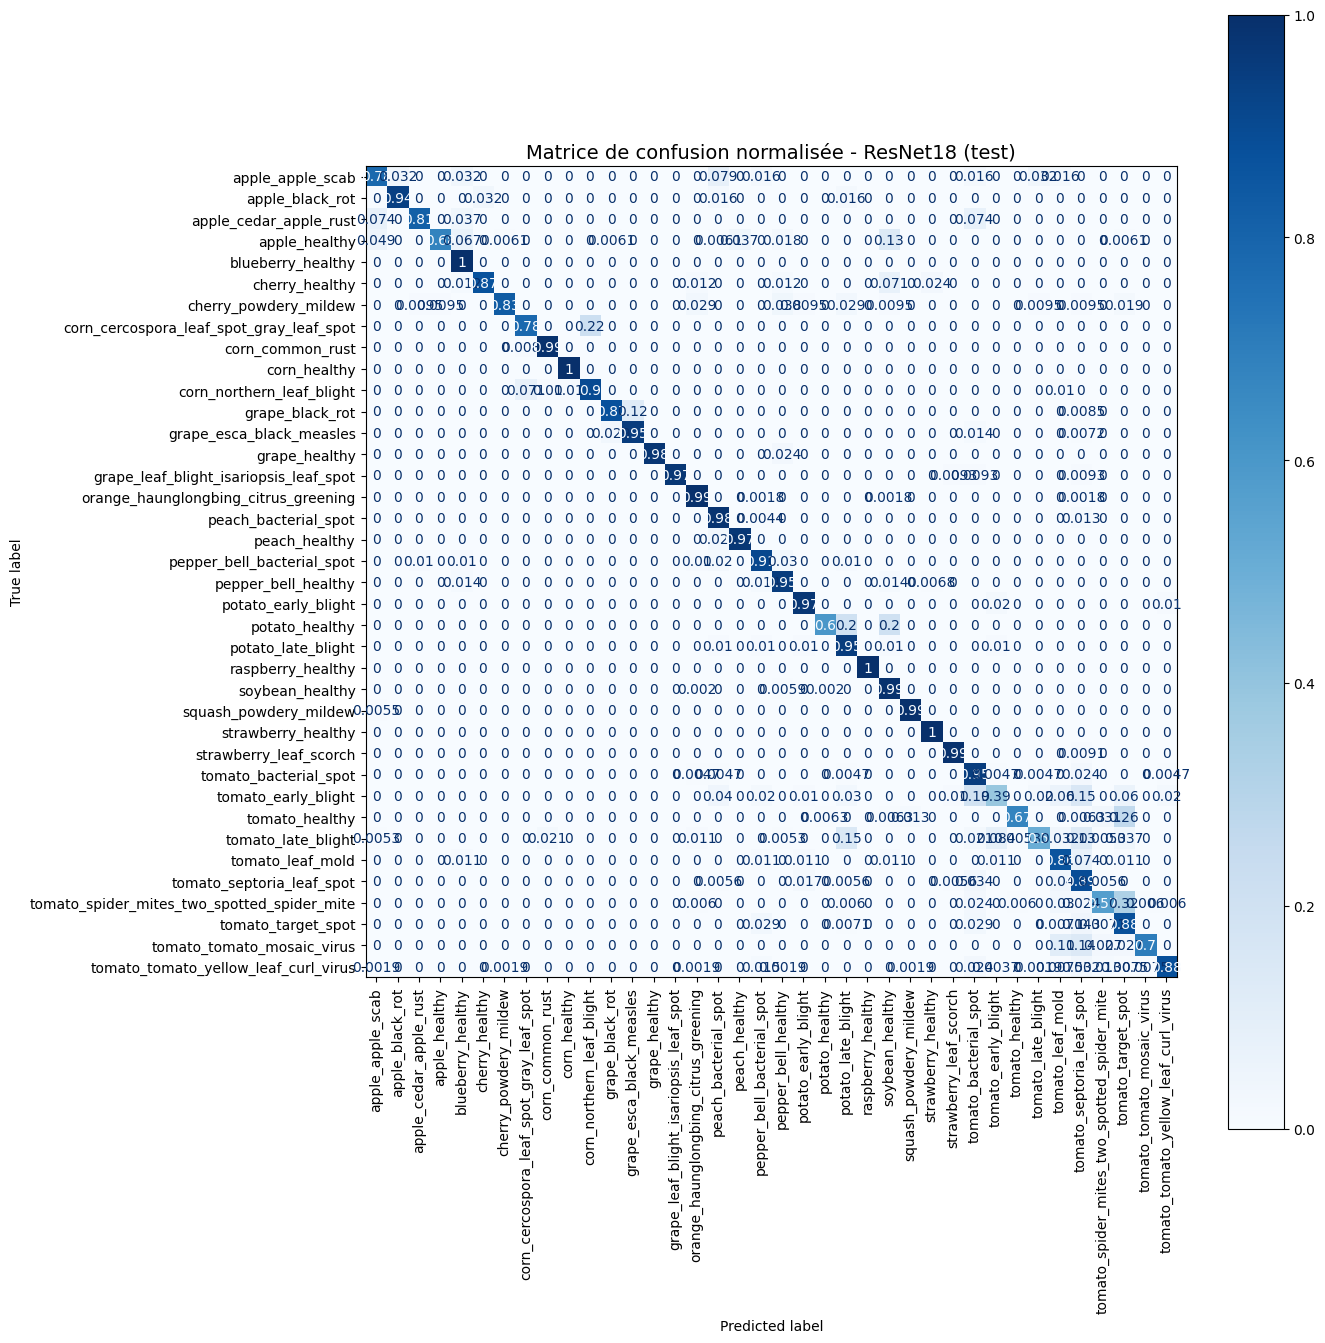

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_res = confusion_matrix(y_true_res, y_pred_res, normalize='true')

fig, ax = plt.subplots(figsize=(14, 14))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_res,
                              display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=90, ax=ax, colorbar=True)

plt.title("Matrice de confusion normalisée - ResNet18 (test)", fontsize=14)
plt.tight_layout()
plt.show()
